# plot oxygen change in CCS region

In [2]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools
import proc_cesm_le

plot_grid_vars = ['TLAT','TLONG','KMT','TAREA','ULAT','ULONG','UAREA',
                  'z_t','z_t_150m','z_w','dz',
                  'area_sum','vol_sum','year','lat_t','lat_t_edges']

### read the CESM-LE ensemble mean data

In [3]:
%%time
varlist = ['O2','AOU']
op = 'ann_dft'
tr85a = {}
for v in varlist:
    file_in = os.path.join(diro['work'],'tr85.avg.%s.%s.1920-2100.nc'%(op,v))
    print('reading %s'%file_in)
    ds = xr.open_dataset(file_in,decode_times=False,decode_coords=False)
    tr85a = xr.merge((tr85a,ds))
tr85a = tr85a.drop([k for k in tr85a if k not in plot_grid_vars and k not in varlist])

v = 'O2sat'
tr85a[v] = tr85a['AOU'] + tr85a['O2']
print tr85a

reading /glade/scratch/mclong/calcs/iucn-ch/work/tr85.avg.ann_dft.O2.1920-2100.nc
reading /glade/scratch/mclong/calcs/iucn-ch/work/tr85.avg.ann_dft.AOU.1920-2100.nc
<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320, time: 181, z_t: 60, z_t_150m: 15, z_w: 60)
Coordinates:
  * z_t       (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
  * z_w       (z_w) float32 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 ...
Dimensions without coordinates: nlat, nlon, time
Data variables:
    O2        (time, z_t, nlat, nlon) float32 nan nan nan nan nan nan nan ...
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 1.124e+13 1.124e+13 ...
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 -79.22 -79.22 -79.22 ...
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 325.1 326.2 327.3 ...
    UAREA     (nlat, nlon) f

### compute baseline mean

In [4]:
%%time
tr85a = tr85a.compute()

CPU times: user 0 ns, sys: 6.79 s, total: 6.79 s
Wall time: 19.3 s


### compute thermocline averages

generate a region mask in 2D

CPU times: user 7.17 s, sys: 19 ms, total: 7.19 s
Wall time: 7.17 s


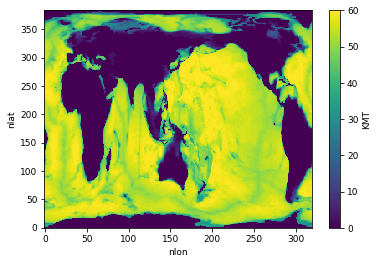

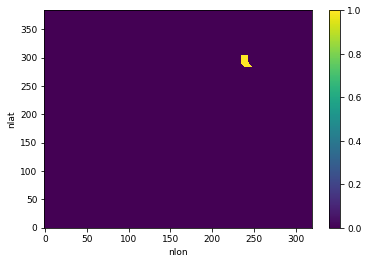

In [97]:
%%time
nz = tr85a.z_t.shape[0]
nlat = tr85a.KMT.shape[0]
nlon = tr85a.KMT.shape[1]
zmask = xr.DataArray(np.ones(nz),dims='z_t')

#800 km of the coast and from ∼33∘N to 46∘N
lat_rng = [33,46]
#lat_rng = [-90,90]
rmask = xr.DataArray(np.zeros((nlat,nlon)),dims=('nlat','nlon'))
rmask[:,:] = np.where((tr85a.KMT > 0) & \
                       (lat_rng[0]<tr85a.TLAT) & (tr85a.TLAT < lat_rng[1]),1., 0.)

#-- work up the N American land mass, find cells near coast
# double check we have the right i-start
if not (rmask[:,275]==0.).all():
    print('wrong i-start')

irng = np.arange(0,nlon,1) # array for constructing logical indexes
for j in range(250,350):
    for i in range(275,200,-1):
        if rmask[j,i] == 1.:
            ndx = ((i-8<=irng)&(irng<= i))
            rmask[j,ndx] = 1.
            rmask[j,np.logical_not(ndx)] = 0.
            break
        elif lat_rng[0]>tr85a.TLAT[j,i] or tr85a.TLAT[j,i]>lat_rng[1]:
            rmask[j,:] = 0.
            
plt.figure()            
tr85a.KMT.plot()
plt.figure()
rmask[:,:].plot()

apply the depth-range mask

(u'z_t', 'nlat', 'nlon')


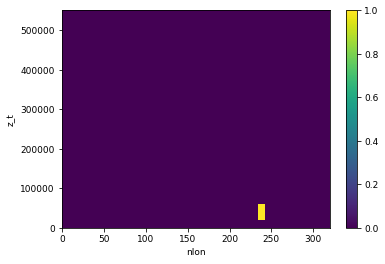

In [6]:
zmask = (tr85a.dz.where( (200e2<=tr85a.z_t)&(tr85a.z_t<=600e2) ) / tr85a.dz.where( (200e2<=tr85a.z_t)&(tr85a.z_t<=600e2)) ).fillna(0.)
rmask = zmask * rmask
print rmask.dims
rmask[:,300,:].plot()

compute the spatial mean for each dataset in the CESM-LE

In [32]:
%%time
varlist = ['O2','AOU']
op = 'ann_dft'
tr85 = []

file_out = os.path.join(diro['out'],'regional-ccs-timeseries.nc')
if not os.path.exists(file_out):
    files = {}
    for v in varlist:
        files[v] = sorted(glob(os.path.join(diro['work'],'tr85.[0-9][0-9][0-9].%s.%s.1920-2100.nc'%(op,v))))

    ds = []
    i = 0
    for path_i in zip(*files.values()):
        print path_i
        dsi = {}
        for path_ii in set(path_i):
            dsii = xr.open_dataset(path_ii,decode_times=False,decode_coords=False)
            dsi = xr.merge((dsi,dsii))

        dsi = dsi.drop([k for k in dsi if k not in plot_grid_vars and k not in varlist])  
        dsi['O2sat'] = tr85a['AOU'] + tr85a['O2']
        dsi = et.pop_calc_spatial_mean(dsi,avg_over_dims=['z_t','nlat','nlon'],region_mask=rmask).load()
        ds.append(dsi)
        i+1
        if i > 3: break
    ds = xr.concat(ds,dim='ens')  
    ds.to_netcdf(file_out)
else:
    ds = xr.open_dataset(file_out,decode_times=False,decode_coords=False)
ds = ds.compute()    
print ds    

<xarray.Dataset>
Dimensions:   (ens: 33, nlat: 384, nlon: 320, time: 181, z_t: 60, z_t_150m: 15, z_w: 60)
Coordinates:
  * z_t       (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
  * z_w       (z_w) float32 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 ...
Dimensions without coordinates: ens, nlat, nlon, time
Data variables:
    KMT       (ens, nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    O2        (ens, time) float64 40.31 41.09 41.71 43.42 44.17 44.36 43.8 ...
    TAREA     (ens, nlat, nlon) float64 1.125e+13 1.125e+13 1.124e+13 ...
    TLAT      (ens, nlat, nlon) float64 -79.22 -79.22 -79.22 -79.22 -79.22 ...
    TLONG     (ens, nlat, nlon) float64 320.6 321.7 322.8 323.9 325.1 326.2 ...
    UAREA     (ens, nlat, nlon) float64 1.423e+13 1.423e+13 1.423e+13 ...
    ULAT      (ens, nlat, nlon) float64 -78.95 -78.95 -78.95 -78.95 -78.95 ...
    ULONG     (ens, nlat, nlon) 

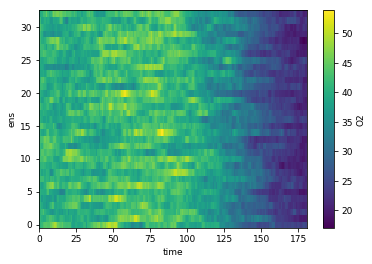

In [33]:
ds.O2.plot()

In [34]:
dsa = ds.mean(dim='ens')
dsa

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320, time: 181, z_t: 60, z_t_150m: 15, z_w: 60)
Coordinates:
  * z_t       (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
  * z_w       (z_w) float32 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 ...
Dimensions without coordinates: nlat, nlon, time
Data variables:
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    O2        (time) float64 40.81 41.29 40.57 40.71 40.49 40.57 40.75 40.49 ...
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 1.124e+13 1.124e+13 ...
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 -79.22 -79.22 -79.22 ...
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 325.1 326.2 327.3 ...
    UAREA     (nlat, nlon) float64 1.423e+13 1.423e+13 1.423e+13 1.423e+13 ...
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 -78.95 -78.95 -78.95 ...
    ULONG     (nlat, nlon) flo

In [67]:
min_yr = 1920
trnd_lngth = xr.DataArray(np.array([10.,20.,60.]),dims=('trend_length'))
trnd_yr = xr.DataArray(np.arange(1920.,2101.,1),dims=('time'))

n_trnd = len(trnd_lngth)
n_yr = len(trnd_yr)
nens = len(ds.ens)

year = xr.DataArray(np.arange(1920.,2101.,1),dims=('time'))
file_out = os.path.join(diro['out'],'regional-ccs-timeseries-trends.nc')

if not os.path.exists(file_out):
    empty_trend = xr.DataArray(np.nan*np.ones((nens,n_yr,n_trnd)),dims=('ens','time','trend_length'))
    trend = xr.Dataset({'trend_length':trnd_lngth,'time':trnd_yr})
    for v in ['O2','AOU','O2sat']:
        trend[v] = empty_trend.copy()
    print trend

    for ie in range(nens):
        print('\tEns #%d'%ie)

        #-- loop over trend year
        for iy in range(n_yr):
  
            #-- loop over trend length
            for ip in range(n_trnd):

                #-- subset record for the right period
                x2 = trnd_yr.values[iy]
                x1 = x2 - trnd_lngth.values[ip] + 1.
                if x1 < min_yr: continue
                tnx = np.where( (x1 <= year) & (year <= x2 ))[0]

                dsi = ds.isel(ens=ie,time=slice(tnx[0],tnx[-1]+1))

                #-- compute trends on each variable
                x = year.isel(time=slice(tnx[0],tnx[-1]+1))
                nt = len(x)
                for v in varlist:
                    y = dsi[v].values
                    beta = np.polyfit(x[np.logical_not(np.isnan(y))],y[np.logical_not(np.isnan(y))],1)
                    trend[v].values[ie,iy,ip] = beta[0]
                    del y
    trend.to_netcdf(file_out)
else:
    trend = xr.open_dataset(file_out,decode_times=False,decode_coords=False)

trenda = trend.mean(dim='ens')
trends = trend.std(dim='ens')
print trend

<xarray.Dataset>
Dimensions:       (ens: 33, time: 181, trend_length: 3)
Coordinates:
  * trend_length  (trend_length) float64 10.0 20.0 60.0
  * time          (time) float64 1.92e+03 1.921e+03 1.922e+03 1.923e+03 ...
Dimensions without coordinates: ens
Data variables:
    O2            (ens, time, trend_length) float64 nan nan nan nan nan nan ...
    AOU           (ens, time, trend_length) float64 nan nan nan nan nan nan ...
    O2sat         (ens, time, trend_length) float64 nan nan nan nan nan nan ...
	Ens #0
	Ens #1
	Ens #2
	Ens #3
	Ens #4
	Ens #5
	Ens #6
	Ens #7
	Ens #8
	Ens #9
	Ens #10
	Ens #11
	Ens #12
	Ens #13
	Ens #14
	Ens #15
	Ens #16
	Ens #17
	Ens #18
	Ens #19
	Ens #20
	Ens #21
	Ens #22
	Ens #23
	Ens #24
	Ens #25
	Ens #26
	Ens #27
	Ens #28
	Ens #29
	Ens #30
	Ens #31
	Ens #32
<xarray.Dataset>
Dimensions:       (ens: 33, time: 181, trend_length: 3)
Coordinates:
  * trend_length  (trend_length) float64 10.0 20.0 60.0
  * time          (time) float64 1.92e+03 1.921e+03 1.922e+03

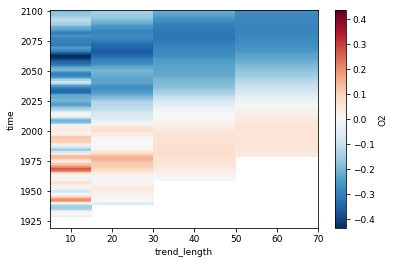

In [66]:
trenda.O2[:,:].plot()

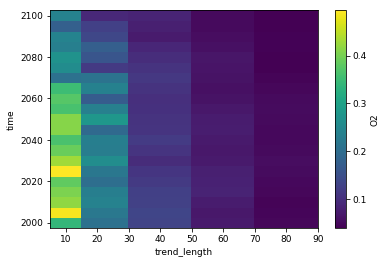

In [56]:
trends.O2.plot()

/glade/p/work/mclong/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less


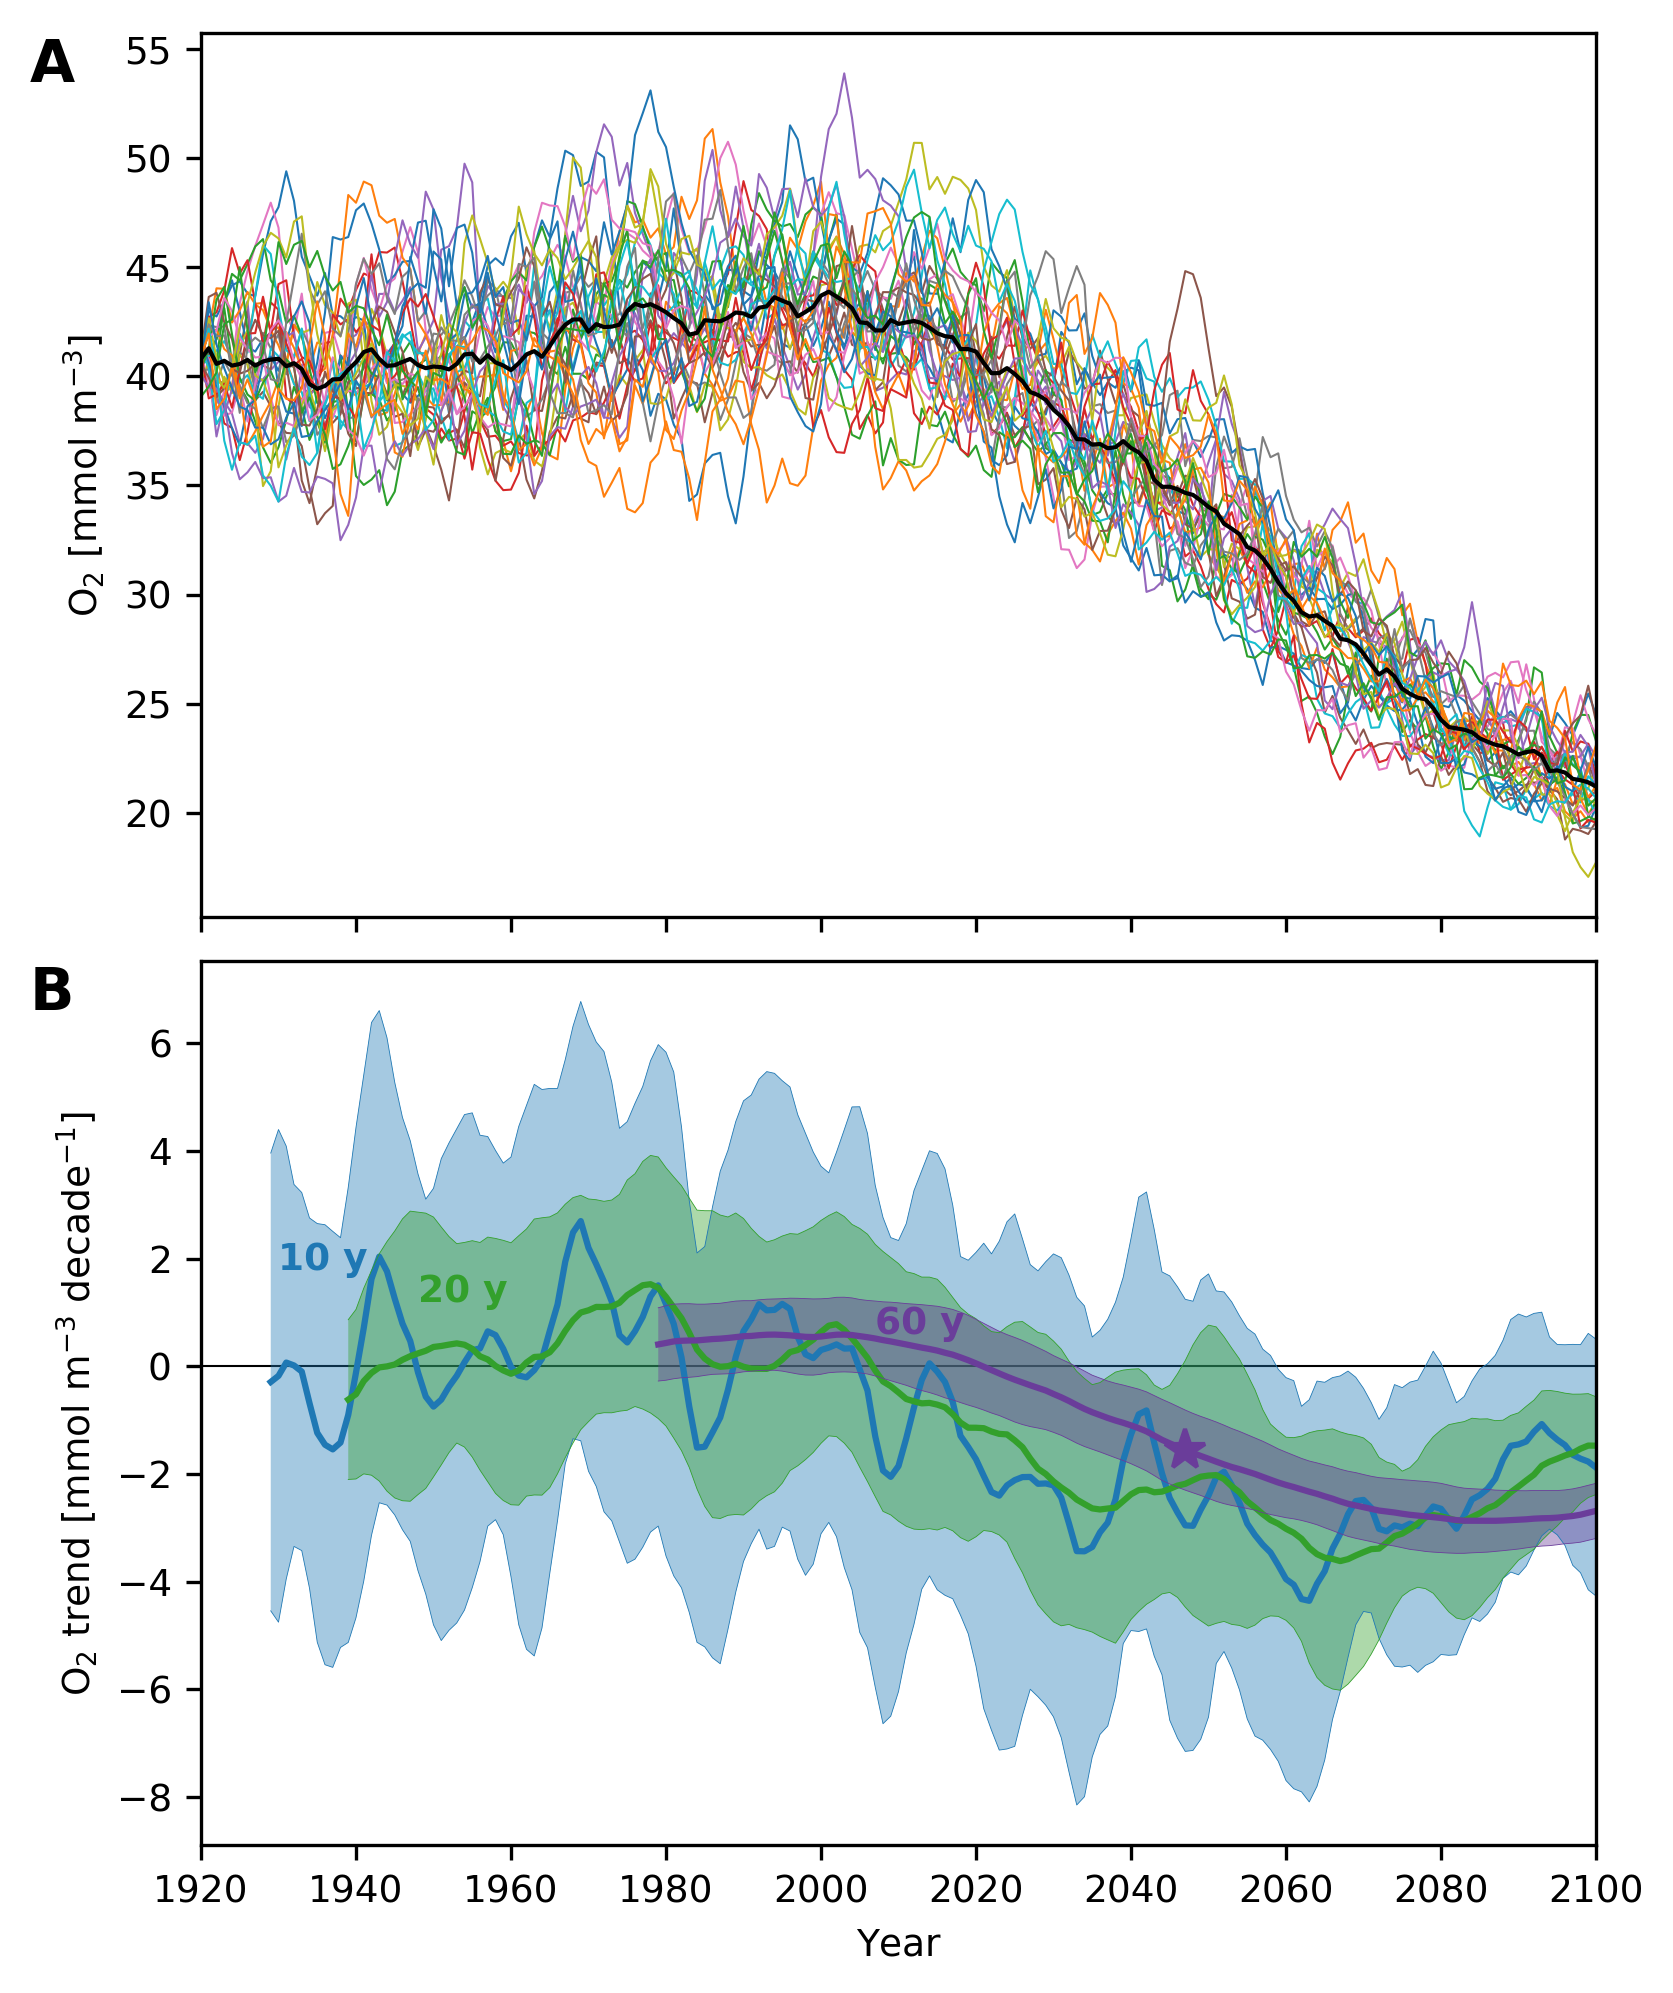

In [94]:
plot_name = os.path.join(diro['fig'],'cesm-regional-ccs-timeseries.pdf')

hexcolor = ['#1f78b4','#33a02c','#6a3d9a','#ff7f00','#e31a1c','#6a3d9a']
#hexcolor = ['#1b9e77','#d95f02','#7570b3']
fig = plt.figure(dpi=300,figsize=(6,8),facecolor='w')
gs = gridspec.GridSpec(2,1)

v = 'O2'

ax = fig.add_subplot(gs[0,0])
ax.set_xlim((1920,2100))
ax.set_ylabel('O$_2$ [mmol m$^{-3}$]')

baseline = dsa[v][0:20].mean()
for ie in range(len(ds.ens)):
    ax.plot(year,ds[v][ie,:],'-',linewidth=0.5)

ax.plot(year,dsa[v],'-',linewidth=1.,color='k')
ax.set_xticklabels([])

ax = fig.add_subplot(gs[1,0])
for ip in range(n_trnd):
    y = trenda[v].values[:,ip]*10
    yl = y - trends[v].values[:,ip]*10
    yu = y + trends[v].values[:,ip]*10
    ax.plot(trnd_yr,y,'-',label='%d yr trends',color=hexcolor[ip])
    ax.plot(trnd_yr,yl,'-',color=hexcolor[ip],linewidth=0.2)
    ax.plot(trnd_yr,yu,'-',color=hexcolor[ip],linewidth=0.2)
    ax.fill_between(trnd_yr,yl,yu,facecolor=hexcolor[ip],alpha=0.4)
    
    detected = False
    s2n = trenda[v].values[:,ip] / trends[v].values[:,ip]
    for l in range(n_yr):
        if (s2n[l:]<-2.).all():
            toex = trnd_yr[l]
            toey = trenda[v].values[l,ip]*10.           
            detected = True
            break
    if detected:
        ax.plot(toex,toey,'*',color=hexcolor[ip],markersize=10)

ax.text(1930,1.8,'%d y'%trnd_lngth[0],color=hexcolor[0],fontweight='bold')
ax.text(1948,1.2,'%d y'%trnd_lngth[1],color=hexcolor[1],fontweight='bold')
ax.text(2007, .6,'%d y'%trnd_lngth[2],color=hexcolor[2],fontweight='bold')

ax.axhline(0,color='k',linewidth=0.5,zorder=-10)
ax.set_xlim((1920,2100))    
ax.set_xlabel('Year')
ax.set_ylabel('O$_2$ trend [mmol m$^{-3}$ decade$^{-1}$]')

gs.update(hspace=0.05)

ax = fig.get_axes()
alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1-0.02
    fig.text(0.03,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')
    
plt.savefig(plot_name,bbox_inches='tight')